In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.utils import resample
from asn.evaluation.metrics import estimateLatency

figure_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/Figures/'
result_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/ModelAnalysis/'
evaluation_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/ModelEvaluation/'

tracker = joblib.load(result_path + 'FiringRates_readout_250620.pkl')

save = False
colors = sns.color_palette(sns.xkcd_palette(["orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))

offset = 0
onset = 100
l = 25
time_steps = np.arange(-onset, tracker[l]['neutral']['MUA'].shape[1] - onset) #np.arange(offset, tracker[25]['neutral']['MUA_centre'].shape[1])
n = tracker[l]['neutral']['MUA'].shape[0]

conds = ['P-1_I-0_O-0.3','P-0_I-0_O-0.3','P-1_I-0.15_O-0','P-0_I-0.15_O-0','P-1_I-0.05_O-0.2','P-0_I-0.05_O-0.2','P-1_I-0_O-0']

start_eval = 100

latencies = pd.DataFrame(np.full((len(conds) * 2 * n, 8), np.nan),
                       columns=['Model', 'Precision', 'Input gain', 'Output gain', 'Attention', 'Trial', 'Latency', 'Peak'])

latencies['Attention'] = np.repeat(np.arange(2)[np.newaxis, :], len(conds) * n, axis=0).flatten()
latencies['Model'] = np.repeat(np.arange(len(conds))[np.newaxis, :], 2 * n, axis=1).flatten()
latencies['Trial'] = np.repeat(np.arange(n)[np.newaxis, :], 2 * len(conds), axis=0).flatten()

replace_map = {'Attention': {0: 'valid', 1: 'invalid'}}
latencies.replace(replace_map, inplace=True)

for c, cond in enumerate(conds):
    print(cond)
    if cond == 'neutral':
        latencies.loc[latencies['Model'] == c, 'Precision'] = False
        latencies.loc[latencies['Model'] == c, 'Input gain'] = 0
        latencies.loc[latencies['Model'] == c, 'Output gain'] = 0
    else:
        splits = cond.split('_')

        latencies.loc[latencies['Model'] == c, 'Precision'] = float(splits[0].split('-')[1])
        latencies.loc[latencies['Model'] == c, 'Input gain'] = float(splits[1].split('-')[1])
        latencies.loc[latencies['Model'] == c, 'Output gain'] = float(splits[2].split('-')[1])

        latencies.loc[latencies['Model'] == c, 'Model'] = cond

latencies_n, local_maxima_n = estimateLatency(tracker[l]['neutral']['MUA'][:n],
                                                      tracker[l]['neutral']['MUA_baseline_average'][:, :,
                                                      tracker[l]['locations'][:, 0], tracker[l]['locations'][:, 1]].T,
                                                      start_eval=start_eval)
latencies_n[latencies_n <= start_eval] = np.nan
local_maxima_n[latencies_n <= start_eval] = np.nan



P-1_I-0_O-0.3
P-0_I-0_O-0.3
P-1_I-0.15_O-0
P-0_I-0.15_O-0
P-1_I-0.05_O-0.2
P-0_I-0.05_O-0.2
P-1_I-0_O-0


No handles with labels found to put in legend.


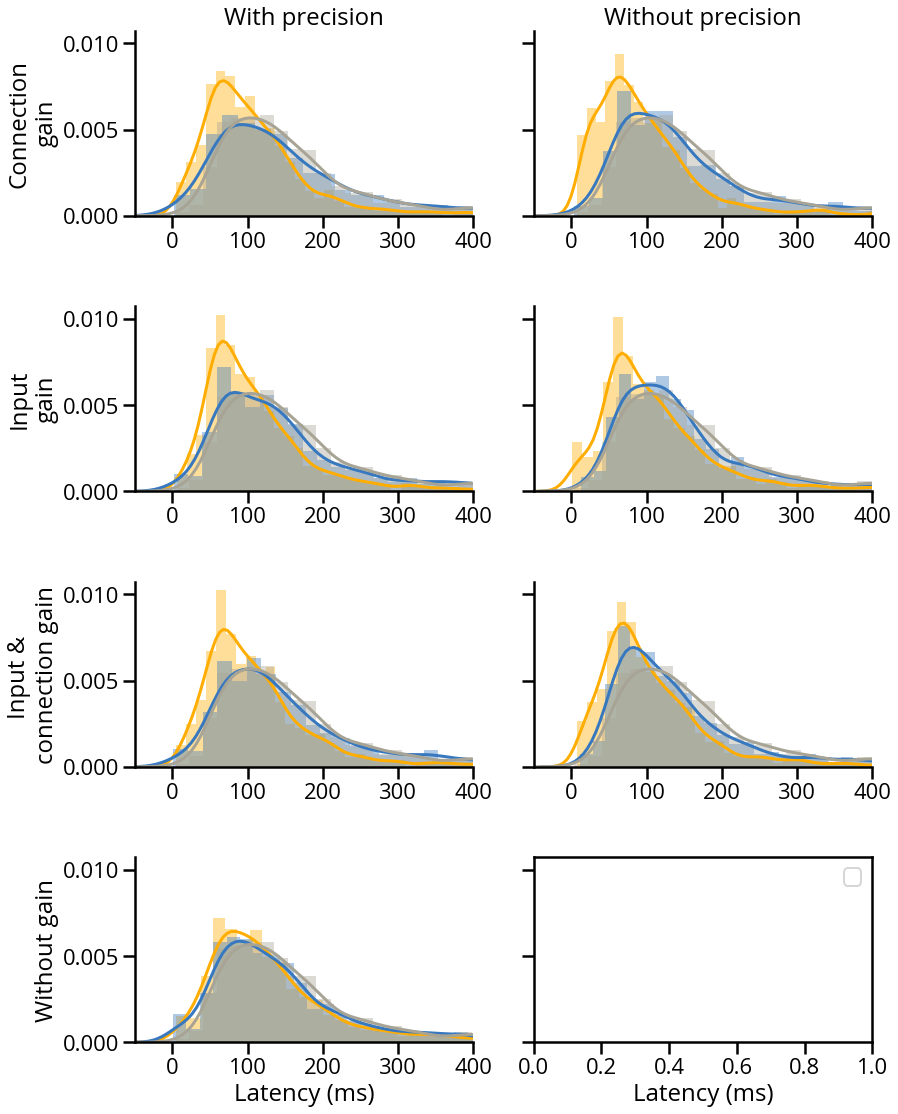

In [2]:
sns.set_context("poster")
fig, ax = plt.subplots(4,2, figsize=(13, 16), sharey=True, sharex=False, constrained_layout=True)

ax = ax.flatten()

for c, cond in enumerate(conds):

    latencies_v, local_maxima_v = estimateLatency(tracker[l][cond]['valid']['MUA'][:n],
                                                  tracker[l][cond]['valid']['MUA_baseline_average'][:, :,
                                                  tracker[l]['locations'][:, 0], tracker[l]['locations'][:, 1]].T,
                                                  start_eval=start_eval)
    # filter out the pre-stimulus responses
    latencies_v[latencies_v <= start_eval] = np.nan
    local_maxima_v[latencies_v <= start_eval] = np.nan

    latencies_i, local_maxima_i = estimateLatency(tracker[l][cond]['invalid']['MUA'][:n],
                                                  tracker[l][cond]['invalid']['MUA_baseline_average'][:, :,
                                                  tracker[l]['locations'][:, 0], tracker[l]['locations'][:, 1]].T,
                                                  start_eval=start_eval)
    latencies_i[latencies_i <= start_eval] = np.nan
    local_maxima_i[latencies_i <= start_eval] = np.nan

    sns.distplot(latencies_v - onset, color=colors[0], label='valid', ax=ax[c])
    sns.distplot(latencies_i - onset, color=colors[1], label='invalid', ax=ax[c])
    sns.distplot(latencies_n - onset, color=colors[2], label='neutral', ax=ax[c])

    latencies.loc[(latencies['Model'] == cond) & (latencies['Attention'] == 'valid'), 'Latency'] = latencies_v
    latencies.loc[(latencies['Model'] == cond) & (latencies['Attention'] == 'invalid'), 'Latency'] = latencies_i
    # latencies.loc[(latencies['Model'] == cond) & (latencies['Attention'] == 'neutral'), 'Latency'] = latencies_n

    latencies.loc[(latencies['Model'] == cond) & (latencies['Attention'] == 'valid'), 'Peak'] = local_maxima_v
    latencies.loc[(latencies['Model'] == cond) & (latencies['Attention'] == 'invalid'), 'Peak'] = local_maxima_i

    if c == 1:
        plt.legend()

    ax[c].set_xlim([-50, 400])
    sns.despine(ax=ax[c])

ax[0].set_ylabel('Connection\ngain')
ax[0].set_xlabel(' ')
ax[0].set_title('With precision')

ax[1].set_title('Without precision')
ax[1].set_xlabel(' ')


ax[2].set_ylabel('Input\ngain')
ax[2].set_xlabel(' ')
ax[3].set_xlabel(' ')

ax[4].set_ylabel('Input & \nconnection gain')
ax[4].set_xlabel(' ')
ax[5].set_xlabel(' ')


ax[6].set_ylabel('Without gain')
ax[6].set_xlabel('Latency (ms)')

ax[7].set_xlabel('Latency (ms)')

plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.tight_layout()
if save == True:
    fig.savefig( figure_path + 'Latencies_allConditions_neutral.pdf', dpi=300, transparent=True)
else:
    plt.show()

Model             Attention
P-0_I-0.05_O-0.2  invalid      129.0
                  valid         48.0
P-0_I-0.15_O-0    invalid      191.0
                  valid         73.0
P-0_I-0_O-0.3     invalid      196.0
                  valid         43.0
P-1_I-0.05_O-0.2  invalid      259.0
                  valid         66.0
P-1_I-0.15_O-0    invalid      234.0
                  valid         71.0
P-1_I-0_O-0       invalid      203.0
                  valid        127.0
P-1_I-0_O-0.3     invalid      325.0
                  valid         62.0
Name: Missing, dtype: float64


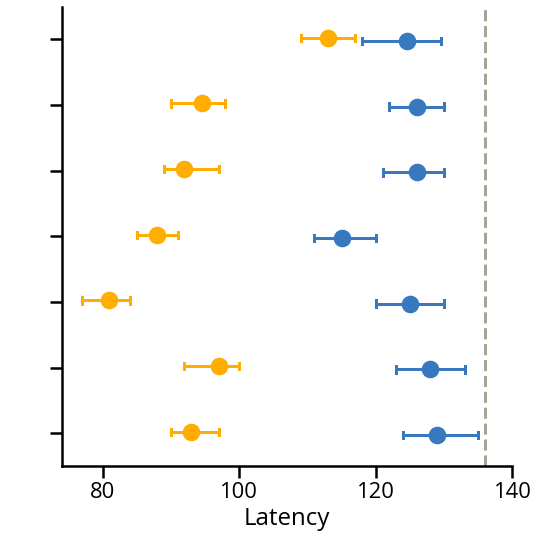

In [3]:
medians = latencies.groupby(['Model', 'Attention'])['Latency'].median() - 100
#print(medians)
latencies['Missing'] = latencies['Latency'].isna()

print(latencies.groupby(['Model', 'Attention'])['Missing'].sum())

latencies['Latency'] = latencies['Latency'] - onset

order = ['P-1_I-0_O-0.3','P-1_I-0.05_O-0.2', 'P-0_I-0_O-0.3','P-0_I-0.05_O-0.2','P-1_I-0.15_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0_O-0']

# make a bar plot with the average FR in Hz

mode = 'points_h'
if mode == 'bars':
    # make a bar plot with the average FR in Hz
    g = sns.catplot(x="Model", y="Latency", hue="Attention", data=latencies[latencies['Attention'] != 'neutral'],
                    height=8, aspect=2.2, kind="bar",
                    palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                    legend=False, estimator=np.median, order=order)


elif mode == 'points':
    dodge = True
    capsize = 0.1
    aspect = 1.85
    # amber, orange yellow

    g = sns.catplot(x="Model", y="Latency", hue="Attention", data=latencies[latencies['Attention'] != 'neutral'],
                    height=8, aspect=aspect, kind="point",
                    palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                    legend=False, zorder=6, estimator=np.median, order=order, join=False, dodge=dodge,
                    capsize=capsize, errwidth=3)

elif mode == 'points_h':
    dodge = True
    capsize = 0.1
    aspect = 1
    errwidth = 3
    order = ['P-1_I-0_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0.15_O-0', 'P-0_I-0.05_O-0.2', 'P-0_I-0_O-0.3', 'P-1_I-0.05_O-0.2',
             'P-1_I-0_O-0.3']

    g = sns.catplot(y="Model", x="Latency", hue="Attention", data=latencies[latencies['Attention'] != 'neutral'],
                    height=8, aspect=aspect, kind="point",
                    palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                    legend=False, zorder=6, estimator=np.median, order=order, join=False, dodge=dodge,
                    capsize=capsize, errwidth=3, orient='h')

    g.set_yticklabels([' ', ' ', ' \n ', ' \n ', ' ',
                       ' \n ', '  \n '])

    mean = np.nanmedian(latencies_n) - onset

    g.ax.set_xticks([80, 100, 120, 140])
    g.ax.set_xlabel('Latency')
    g.ax.set_ylabel(' ')
    g.ax.axvline(mean, c=colors[2], ls='--', zorder=0)

    plt.tight_layout()
    sns.despine(top=True, right=True)
    if save == True:
        g.savefig(figure_path + 'Latencies_' + mode + '.pdf', dpi=300, transparent=True)
    else:
        plt.show()
else:
    raise ValueError("Not implemented.")

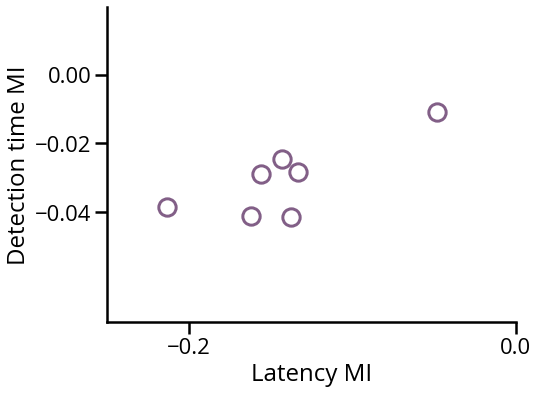

In [4]:
RT_filename = evaluation_path + 'RTs_150620.pkl'
RTs = pd.read_pickle(RT_filename)

med_RT = RTs.groupby(['Model', 'Attention']).median().reset_index()
med_latency = latencies.groupby(['Model', 'Attention']).median().reset_index()

AI = pd.DataFrame(np.zeros((len(conds), 4)), columns=['Model', 'Precision', 'Latency-AMI', 'RT-AMI'])

for c, cond in enumerate(conds):
    AI.loc[c, 'Model'] = cond
    AI.loc[c, 'Precision'] = bool(int(cond.split('_')[0].split('-')[1]))
    #cond.split('_')[0].split('-')[1]
    validRT = med_RT.loc[(med_RT['Model'] == cond) & (med_RT['Attention'] == 'valid'), 'RT'].values
    invalidRT = med_RT.loc[(med_RT['Model'] == cond) & (med_RT['Attention'] == 'invalid'), 'RT'].values
    AI.loc[c, 'RT-AMI'] = (validRT - invalidRT)/ (validRT + invalidRT)

    validlat = med_latency.loc[(med_latency['Model'] == cond) & (med_latency['Attention'] == 'valid'), 'Latency'].values
    invalidlat = med_latency.loc[(med_latency['Model'] == cond) & (med_latency['Attention'] == 'invalid'), 'Latency'].values
    AI.loc[c, 'Latency-AMI'] = (validlat - invalidlat)/ (validlat + invalidlat)


fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(AI['Latency-AMI'],AI['RT-AMI'],c='white', edgecolor=colors[4], s=300, linewidths= 3)

ax.set_xlabel('Latency MI')
ax.set_ylabel('Detection time MI')
ax.set_xlim([-0.25,0])
ax.set_xticks([-0.2, 0])
ax.set_yticks([-0.04, -0.02, 0])
sns.despine()
plt.tight_layout()
if save == True:
    fig.savefig(figure_path + 'Latencies_AMI.pdf', dpi=300, transparent=True)
else:
    plt.show()


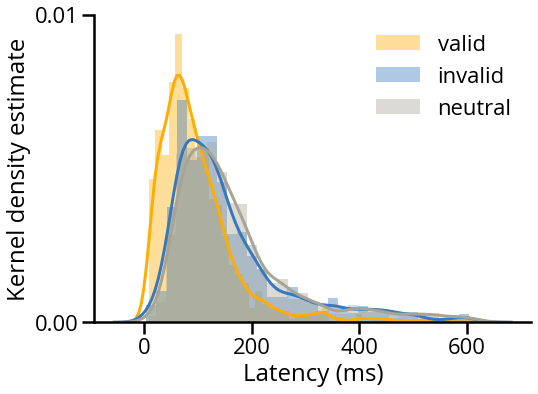

In [5]:
cond = 'P-0_I-0_O-0.3'

sns.set_context("poster")
onset = 100
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(latencies.loc[(latencies['Model'] == cond) & (latencies['Attention'] == 'valid'), 'Latency'],
             color=colors[0], label='valid', ax=ax)
sns.distplot(latencies.loc[(latencies['Model'] == cond) & (latencies['Attention'] == 'invalid'), 'Latency'],
             color=colors[1], label='invalid', ax=ax)
sns.distplot(latencies_n- onset, color=colors[2], label='neutral', ax=ax)
plt.legend(frameon=False)
sns.despine()
ax.set_ylabel('Kernel density estimate')
ax.set_xlabel('Latency (ms)')
ax.set_yticks([0,0.01])
plt.tight_layout()
if save == True:
    fig.savefig(figure_path + 'Latencies_example.pdf', dpi=300, transparent=True)
else:
    plt.show()

In [ ]:
# Statistical analysis, pairwise comparisons per condition
import random

comps = ['valid vs invalid','invalid vs neutral', 'valid vs neutral']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])

# Define p (number of permutations):
p = 1000

results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)

neutralPreds = latencies_n - onset
for cond in order:
    if cond not in results:
        results[cond] = {}
    print(cond)
    validPreds = latencies.loc[(latencies['Model']==cond) & (latencies['Attention']=='valid'), 'Latency'].values
    invalidPreds = latencies.loc[(latencies['Model']==cond) & (latencies['Attention']=='invalid'), 'Latency'].values
    idx = np.arange(len(validPreds) * 2)
    for comp in comps:
        if comp not in results[cond]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(np.nanmedian(validPreds) - np.nanmedian(invalidPreds))
                samplePreds = np.concatenate([validPreds, invalidPreds], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(np.nanmedian(neutralPreds) - np.nanmedian(validPreds))
                samplePreds = np.concatenate([validPreds, neutralPreds], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(np.nanmedian(neutralPreds) - np.nanmedian(invalidPreds))
                samplePreds = np.concatenate([invalidPreds, neutralPreds], axis=0)

            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)
                pD.append(np.abs(np.nanmedian(samplePreds[idx[:int(len(idx)//2)]]) - np.nanmedian(samplePreds[idx[int(len(idx) // 2):]])))

            p_val = len(np.where(pD>=diff)[0])/p
            print(cond + ': ' + str(p_val))

            results[cond][comp] = {}
            results[cond][comp]['Observed difference'] = diff
            results[cond][comp]['Difference distribution'] = pD
            results[cond][comp]['p-value']= p_val

            results_df = results_df.append({'Mechanism':cond, 'Comparison':comp, 'Difference':diff, 'p-values':p_val, 'significant':p_val<results['alpha-level']},ignore_index=True )


joblib.dump(results,result_path + 'LatencyPermutationTestsComparisons.pkl',
            compress=True)
results_df.to_csv(result_path + 'LatencyPermutationTestsComparisons_df.csv')




